# LSTM Time Series - Stock Price Prediction
## Part 1 - Exploratory Data Analysis
This notebook focuses on examining the raw dataset containing daily historical prices of Google stocks. The goal is to identify a specific timeframe suitable for further analysis and prediction using LSTM.

> **INPUT**: The raw data file of all available stock prices of Google (Alphabet Inc.), as downloaded from its original source. <br/>
> **OUTPUT**: The extracted historical data of the targeted period for analysis, stored in an intermediary location for next steps.

### 1. INITIALIZATION

In [50]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

### 2. LOAD DATASET FILE

The dataset we are going to initially load and explore is the historical records of daily price details of Google (Alphabet Inc.) sourced from [Yahoo Finance](https://finance.yahoo.com/quote/GOOG).

At first, we load the complete dataset available spanning a period from 2004-08-19 up until April-2024

The main objective of loading the entire dataset is to choose a particular time frame for analysis.

In [7]:
# Prepare data file location and load the dataset

data = pd.read_csv('/content/google_stock_price_full.csv')

In [5]:
# Check dataset shape
data.shape

(4940, 7)

In [6]:
# Check dataset head
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [8]:
# Check data types
data.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


### 3. INITIAL DATA CLEANING

As we notice, the Date column is currently in a String format which requires conversion to proper Datetime format.

In [9]:
# Convert Date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

In [10]:
# Check column format
data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


### 4. EXPLORE DATASET

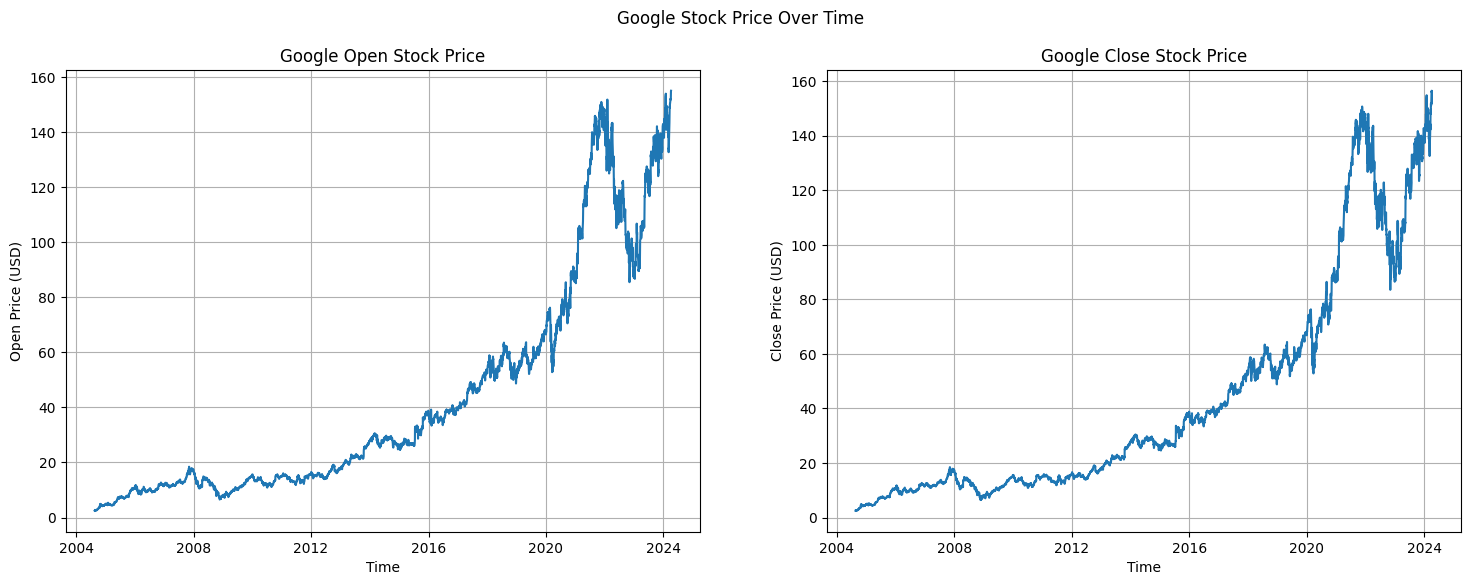

In [11]:
# Plot Open and Close price for the whole period
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price (USD)")
plt.title("Google Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Close"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Google Close Stock Price")
plt.grid()

plt.suptitle("Google Stock Price Over Time")
plt.show()

The previous charts show an inconsistent behavior in the stock's performance over time, with a completely distinct trend during the past five years.

This means that the old historical data might not be relevant to the predictions, since it's most likely to represents a different period with outdated indicators that don't affect the current trend.

Accordingly, we will concentrate our analysis on the most recent five-year data, as it is expected to provide more accurate insights for predicting future trends.

In [12]:
# Select stock price records for the last five years, starting from 2019
data_5years = data[data["Date"].dt.year >= 2019]

# Check filtered data shape
data_5years.shape

(1323, 7)

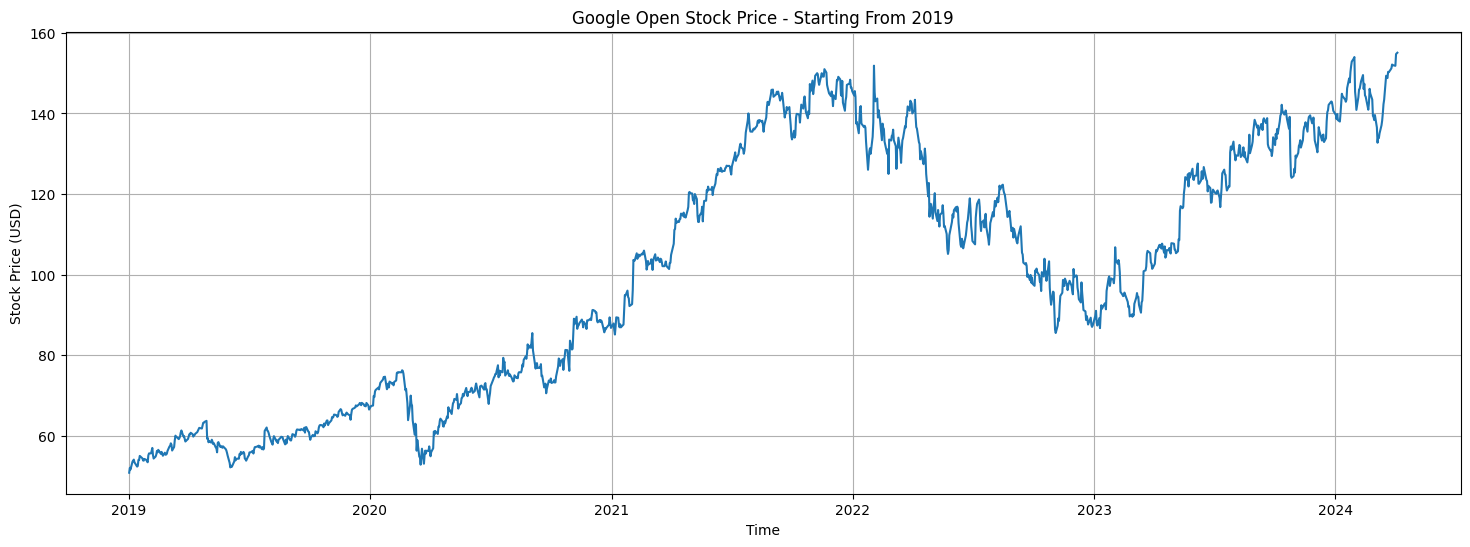

In [13]:
# Plot Open stock price performance in the last five years
plt.figure(figsize=(18,6))
plt.plot(data_5years["Date"], data_5years["Open"])
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.title("Google Open Stock Price - Starting From 2019")
plt.grid()

The selected period seems to be more relevant for analysis, as it's more likely to drive the stock performance with the impact of other external factors.

### 5. FILTERED DATASET

In [22]:
data_5years.to_csv("google_stock_price_recent.csv", index=None)
pd.set_option("display.width", 120)

In [26]:
data = pd.read_csv('/content/google_stock_price_recent.csv')
data.shape

(1323, 7)

In [27]:
# Check loaded data head
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000
1,2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000
2,2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000
3,2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000
4,2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000


In [30]:
# Check columns types
data.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


### 6. DATA PREPROCESSING
Validate Data Types

In [31]:
# Convert date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Check column types
data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64



Select Independent Features

The objective of this analysis is to implement a multi-variant prediction, taking into account possible impact of several independent features such as the Open price, Close price and Volume on future stock price performance.

Therefore, in this analysis, we will incorporate all the available variables:

  

*   Opening price
*   Highest price
*   Lowest price
*   Closing price
*   Adjusted closing price
*   Trading volume


These features will be utilized to forecast the future opening price.


In [32]:
# Define selected features and target attribute
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
target = "Open"


Create Train, Validation, and Test Datasets

To monitor and assess the performance of our model, we will partition the recent stock price dataset into three segments: training, validation, and testing sets.

The division will be structured as follows:



*   Training dataset: covering the period from the start of 2019 till June, 2023.
*   Validation dataset: representing the stock prices from July, 2023 till the end of 2023.
*   Testing dataset: representing the stock prices for the first two months of 2024.


In [33]:
# Define start and end time for each period
train_end_date = pd.to_datetime("2023-06-30")
validate_start_date = pd.to_datetime("2023-07-01")
validate_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-01-01")
test_end_date = pd.to_datetime("2024-02-29")

# Split dataset into training, validation, and testing
data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]
data_validate = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)][features]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)][features]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]

In [34]:
# Display the shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (1132, 6)
Validation Set: (126, 6)
Testing Set: (41, 6)


In [35]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
        Open       High        Low      Close  Adj Close    Volume
0  50.828499  52.616001  50.785500  52.292500  52.292500  30652000
1  52.049999  52.848999  50.703499  50.803001  50.803001  36822000
2  51.629501  53.542000  51.370899  53.535500  53.535500  41878000
3  53.575001  53.700001  52.737999  53.419498  53.419498  39638000
4  53.805500  54.228001  53.026501  53.813999  53.813999  35298000
Validation Dataset:
            Open        High         Low       Close   Adj Close    Volume
1132  120.320000  121.019997  119.705002  120.559998  120.559998  13888300
1133  120.059998  123.370003  120.059998  122.629997  122.629997  17830300
1134  120.639999  121.150002  119.250000  120.930000  120.930000  17732500
1135  120.889999  121.750000  120.089996  120.139999  120.139999  20982400
1136  119.070000  119.070000  116.639999  116.870003  116.870003  32960100
Testing Dataset:
            Open        High         Low       Close   Adj Close    Volume
1258  139.600006  

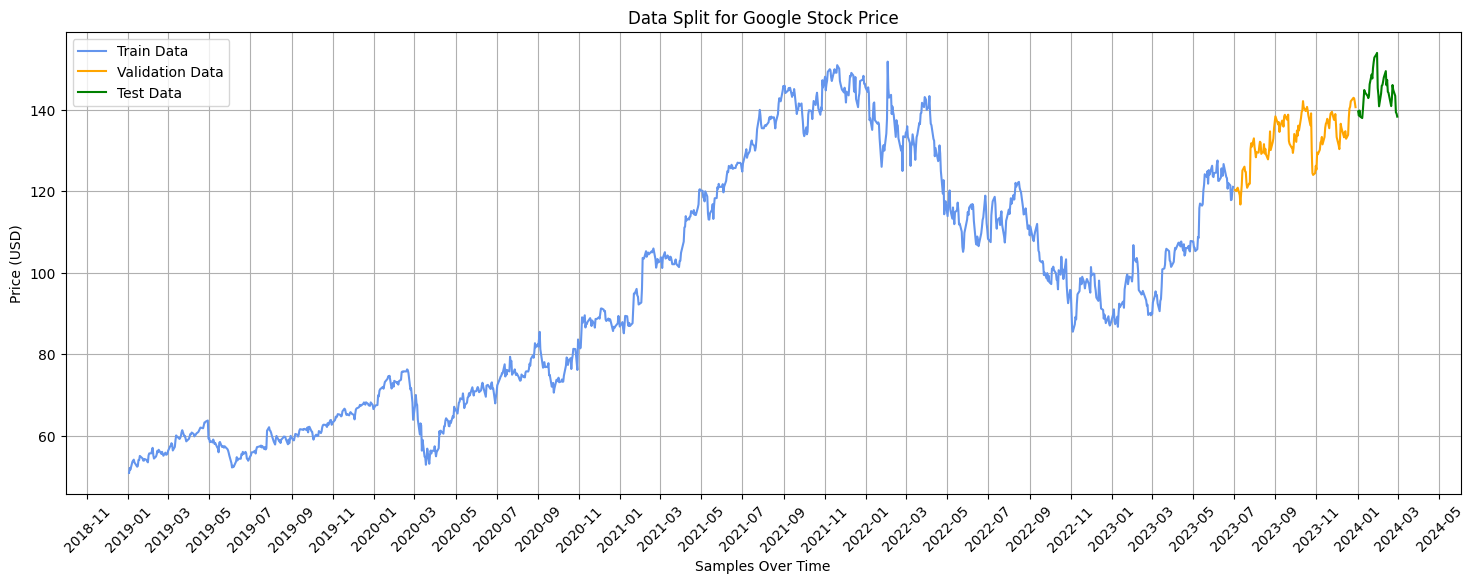

In [36]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Google Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

Data Scaling

In [37]:
# Check the distribution of input features
data[features].describe()

,Open,High,Low,Close,Adj Close,Volume
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1.323000e+03
mean,100.882880,102.042442,99.853834,100.974635,100.974635,2.882756e+07
std,31.078299,31.360869,30.780336,31.059813,31.059813,1.268332e+07
min,50.828499,52.374500,50.676800,50.803001,50.803001,6.936000e+06
25%,71.211247,71.905250,70.356251,70.992001,70.992001,2.076335e+07
50%,102.825996,103.927498,101.500000,102.751503,102.751503,2.575600e+07
75%,130.778503,132.021675,129.389999,130.440002,130.440002,3.287305e+07
max,155.080002,157.000000,154.132004,156.500000,156.500000,1.241400e+08




Looking at these details, it's noticeable and anticipated that all price values exhibit similar distributions given they log the price fluctuation on daily basis.

Conversely, the trading volume presents a distinct distribution that differs significantly.

Accordingly, input features need to be transformed into a unified scale and since the distribution doesn't indicate any outliers, we will use the [0,1] range to normalize all features.

To prevent data leakage, we will fit the scaler solely to the training data. Subsequently, we will use this fitted scaler to transform the training, validation, and testing datasets.


In [38]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

### 7. STORING PROCESSED DATASETS



The training, validation, and testing datasets have been processed and are prepared for training the LSTM model in the next phase.

Prior to saving these datasets, it is necessary to reassemble the dates corresponding to each dataset. This will facilitate later evaluation of the model's performance.

In [40]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [41]:
# Store datasets
data_train_scaled_final.to_csv("google_stock_price_processed_train.csv", index=None)
data_validate_scaled_final.to_csv("google_stock_price_processed_validate.csv", index=None)
data_test_scaled_final.to_csv("google_stock_price_processed_test", index=None)

## Part 2 - Model Training
With the EDA done and duster, we now import the scaled dataset files, prepare them in a format suitable for LSTM modeling, and proceed to train the LSTM model.

> **INPUT**: Scaled dataset files for training, validation, and testing periods, as processed in the preceding phase. <br/>
> **OUTPUT**: Trained LSTM model and analysis of its performance.

### 1. INITIALIZATION

### 2. LOADING DATASETS

In [42]:
# Load data files
data_train_df = pd.read_csv('/content/google_stock_price_processed_train.csv')
data_validate_df = pd.read_csv('/content/google_stock_price_processed_validate.csv')
data_test_df = pd.read_csv('/content/google_stock_price_processed_test')

In [43]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1132, 7)
Validation Dataset Shape: (126, 7)
Testing Dataset Shape: (41, 7)


In [44]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.000000  0.002422  0.001096  0.014909   0.014909  0.202348  2019-01-02
1  0.012090  0.004758  0.000269  0.000000   0.000000  0.254991  2019-01-03
2  0.007928  0.011707  0.006996  0.027351   0.027351  0.298130  2019-01-04
3  0.027184  0.013291  0.020776  0.026190   0.026190  0.279018  2019-01-07
4  0.029465  0.018586  0.023684  0.030138   0.030138  0.241988  2019-01-08
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.687796  0.688344  0.695774  0.698226   0.698226  0.059318  2023-07-03
1  0.685223  0.711909  0.699352  0.718946   0.718946  0.092952  2023-07-05
2  0.690964  0.689648  0.691188  0.701930   0.701930  0.092117  2023-07-06
3  0.693438  0.695665  0.699654  0.694022   0.694022  0.119846  2023-07-07
4  0.675424  0.668791  0.664880  0.661292   0.661292  0.222041  2023-07-10
Testing Dataset:
       Open      High       Low     Close  Ad

### 3. DATA PREPROCESSING

The dataset has already undergone the primary preprocessing and transformation in the pervious phase. This section is only to display the data and extract features and dates.

In [45]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [46]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [47]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

### 4. CONSTRUCTING DATA STRUCTURE

Given that we are addressing a time series problem involving multiple predictors, our task involves constructing and reshaping the input data to suit the LSTM model.

This entails setting a sliding time window (sequence size) that determines the number of past observations used to predict the subsequent value.

In this experiment, we employ a sequence of previous samples (financial days) of all variables to forecast the opening price on the following day.

In [48]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).

    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.

    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """

    # Initialize constructed data variables
    data_X = []
    data_y = []

    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])

    # Return constructed variables
    return np.array(data_X), np.array(data_y)

The construction function is currently available for constructing subsets for training, validation, and testing date that is aligned with the LSTM model input.

In [51]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

Because creating input data requires observations from previous samples, constructing subsets for the validation and testing periods suggests we append data from previous periods.

For instance, to predict the initial stock price in the validation period, we must combine recent actual stock prices (sequence) from the training period. This step is crucial for providing the LSTM model with the expected sequence.

Same principle applies to stock performance during the testing phase but in this case (and depending on the sequence size), we may need to combine samples from both validation and testing subsets.

To facilitate this step, we combine the whole scaled dataset together and then select corresponding chunks before constructing the input data sets.

In [52]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [53]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1299, 6)

 Data Train Scaled: (1132, 6)
> Data Train X: (1072, 60, 6)
> Data Train y: (1072,)

 Data Validate Scaled: (126, 6)
> Data Validate X: (126, 60, 6)
> Data Validate y: (126,)

 Data Test Scaled: (41, 6)
> Data Test X: (41, 60, 6)
> Data Test y: (41,)


### 5. TRAINING LSTM MODEL

#### Building LSTM Model

In [54]:
# Initializing the model
regressor = Sequential()

In [55]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [56]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [57]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [58]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [59]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [60]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [61]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

#### Training Model

In [68]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "\content"
model_name = "google_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)


In [63]:
# Training the model
history = regressor.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_validate, y_validate),
    epochs=200,
    batch_size = 64,
    callbacks = [best_model_checkpoint_callback])

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 388ms/step - loss: 0.0976 - val_loss: 0.0176
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step - loss: 0.0097 - val_loss: 0.0040
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 408ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 489ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 326ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━

#### Performance Evaluation

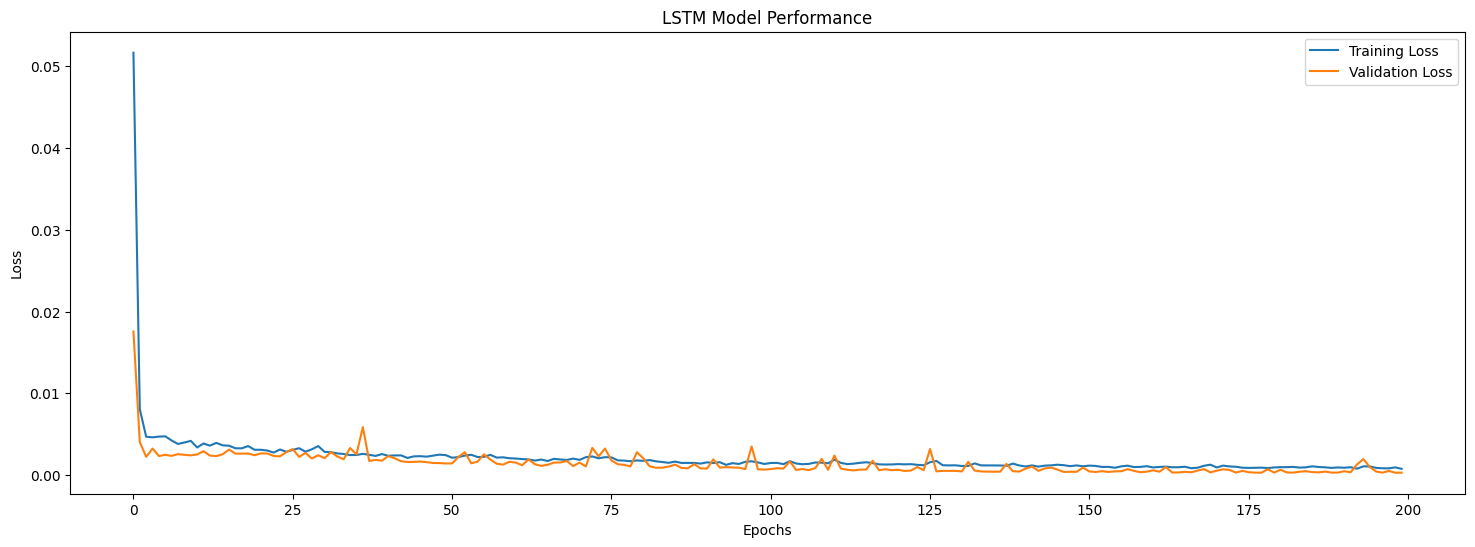

In [64]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


The chart above highlights the following observations:
- Training loss values decrease over the epochs, starting from a higher value and gradually decreasing. This indicates that the model is learning to fit the training data better as training progresses.
- Similarly, the validation loss values also decrease initially, indicating improvement in the model's ability to generalize to unseen data (validation set).
- Some fluctuations in the validation loss have been observed, which is quite justifiable due to the high variations and complexity in the price performance over time.
- There are no signs of overfitting since both loss values are continuously decreasing along with each other over the epochs.
- Validation loss has maintained lower values than training loss across almost the whole training period, which is quite normal due to the complexity/size of training data.

### 6. MODEL INFERENCE

The LSTM model has been trained and evaluated, making it ready to forecast future price trends.

As mentioned earlier, we will employ our model to predict Google stock prices during the testing period. To thoroughly assess the model's performance, we will forecast stock performance for the entire period, including testing samples, and compare these predictions with actual prices.

#### Load Best Model

In [69]:
best_model = load_model('/content/google_stock_price_lstm.model.keras')

#### Model Prediction

In [70]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


#### Inverse Scaling

One important thing to consider is the scale of the datasets, because the model was trained on scaled data that needs to be transformed back to its original price range.

Therefore, we have to load the same scaler used for transforming the original dataset and apply it to restore the prediction outputs to their actual distribution.


The scaler was initially fitted on data with 6 columns encompassing all the features considered. However, during the inverse transformation process, our focus is solely on transforming the "Open" price.

To circumvent potential errors triggered by the inverse_transform API, we create a container structure of the necessary shape. We populate the first column with predictions and subsequently disregard the others.


In [78]:
sc = joblib.load('/content/google_stock_price_scaler.gz')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [79]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

#### Display Predictions

In [80]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

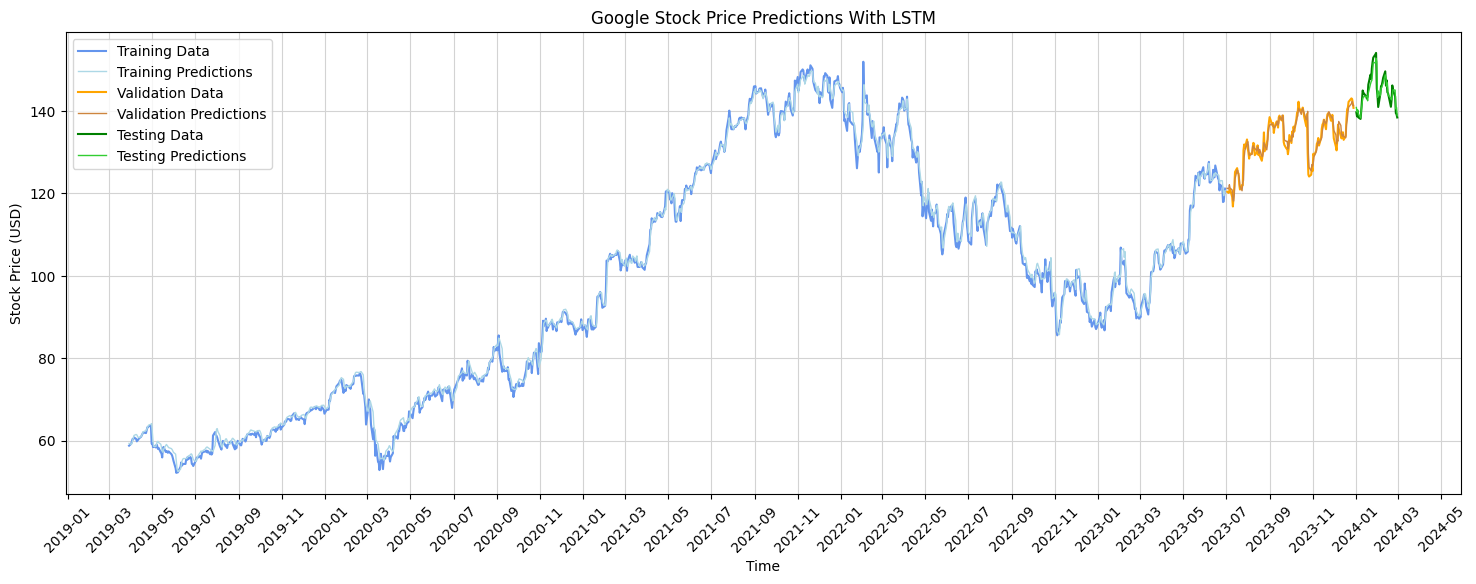

In [81]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

Based on this expanded overview, the model appears to perform very well throughout the observed period, with the predicted trend tends to align closely with actual stock performance across the three training, validation, and testing periods.

To better assess the model's predictions during the validation and testing periods, let's inspect a zoomed-in version of this chart covering the most recent samples.

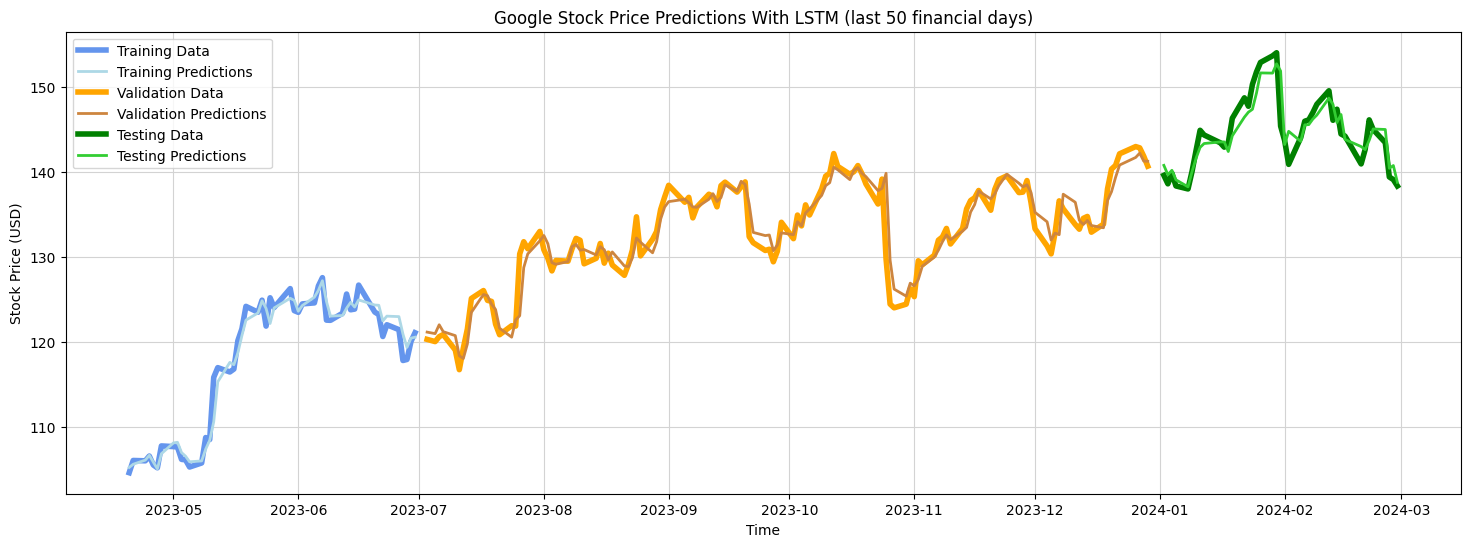

In [82]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM (last 50 financial days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

This closer look underscores the great performance of our LSTM model in predicting Google's stock prices during both validation and testing periods. Indicating the ability of this model to generalize on unseen data that was not included in the training set.

Despite the exact value predictions might be slightly different from real prices, the strong performance of this model is primarily derived from its ability to consistently mirror the actual trends across almost all phases. This is the most significant takeaway of stock price predictions analysis.